In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def generate_time_slot_price_report_pro(
    df: pd.DataFrame, 
    product_name: str, 
    start_date: str = None, 
    end_date: str = None,
    exclude_dates: list = None,
    exclude_tables: list = None, 
    exclude_payments: list = None
) -> pd.DataFrame:
    """
    Analyzes the price history of a product for a specific date range,
    excluding specified dates, and returns a summary DataFrame.

    The logic involves:
    1. Filtering the data based on product and exclusion criteria.
    2. Assigning sales to time slots (e.g., 'Slot_12_to_18', 'Base_Price_Hours').
    3. Aggregating the most frequent (mode) price for each slot, each day.
    4. Intelligently filling missing daily data using monthly modes.
    5. Filling any remaining gaps in the date range using forward/backward fill.
    6. Detecting change points to define stable price periods.
    7. Generating a final, structured DataFrame as the report and a plot.

    Args:
        df (pd.DataFrame): Input DataFrame. Must have a 'Date' column and others like 'Item', 'Table', 'Payment'.
        product_name (str): The name of the product to analyze.
        start_date (str, optional): The start of the date range (e.g., '2023-01-01'). Defaults to None.
        end_date (str, optional): The end of the date range (e.g., '2023-03-31'). Defaults to None.
        exclude_dates (list, optional): A list of specific dates to exclude (e.g., ['2023-01-01']). Defaults to None.
        exclude_tables (list, optional): A list of table numbers to exclude. Defaults to None.
        exclude_payments (list, optional): A list of payment methods to exclude. Defaults to None.
        
    Returns:
        pd.DataFrame: A DataFrame summarizing the price history periods with columns for
                      start/end dates, base price, discount prices, and discount percentages.
                      Returns an empty DataFrame if no data is found for the given criteria.
    """
    print(f"--- Starting Pro Analysis for: {product_name.title()} ---")

    # --- 1. DATA FILTERING AND PREPARATION ---
    # Convert 'Date' column to datetime objects first for all filtering
    df['Date'] = pd.to_datetime(df['Date'])
    
    # === NEW FEATURE: Filter by date range and exclude dates ===
    filtered_df = df.copy()
    if start_date:
        filtered_df = filtered_df[filtered_df['Date'] >= pd.to_datetime(start_date)]
    if end_date:
        # .replace() ensures we include the entire end day up to the last second
        filtered_df = filtered_df[filtered_df['Date'] <= pd.to_datetime(end_date).replace(hour=23, minute=59, second=59)]
    if exclude_dates:
        # Convert list of date strings to datetime objects at date level (ignoring time)
        dates_to_exclude = pd.to_datetime(exclude_dates).date
        filtered_df = filtered_df[~filtered_df['Date'].dt.date.isin(dates_to_exclude)]
    
    print(f"Original records: {len(df)}, After date filtering: {len(filtered_df)}")
    
    # Apply other filters for product, tables, and payments
    mask = (filtered_df["Item"].str.lower() == product_name.lower())
    if exclude_tables:
        mask &= (~filtered_df["Table"].isin(exclude_tables))
    if exclude_payments:
        mask &= (~filtered_df["Payment"].isin(exclude_payments))
    
    item_df = filtered_df[mask].copy()
    
    if item_df.empty:
        print(f"Error: No data found for '{product_name}' with the given filters.")
        return pd.DataFrame() # Return empty DataFrame

    item_df = item_df.sort_values('Date')
    item_df['Sale_Date'] = item_df['Date'].dt.date
    item_df['Sale_Hour'] = item_df['Date'].dt.hour
    
    # --- 2. ASSIGN TIME SLOTS ---
    def assign_time_slot(hour):
        if 12 <= hour < 18: return 'Slot_12_to_18'
        elif 18 <= hour < 19: return 'Slot_18_to_19'
        elif 19 <= hour <= 23 or 0 <= hour < 2: return 'Base_Price_Hours'
        else: return 'Outside_Sale_Hours'
    item_df['Time_Slot'] = item_df['Sale_Hour'].apply(assign_time_slot)
    
    # --- 3. DAILY PRICE AGGREGATION (PIVOT) ---
    safe_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan
    daily_prices = item_df.pivot_table(index='Sale_Date', columns='Time_Slot', values='Price', aggfunc=safe_mode).reset_index()
    for slot in ['Base_Price_Hours', 'Slot_12_to_18', 'Slot_18_to_19']:
        if slot not in daily_prices.columns:
            daily_prices[slot] = np.nan
    
    # --- 4. INTELLIGENT FILLING USING MONTHLY MODES ---
    daily_prices['Month'] = pd.to_datetime(daily_prices['Sale_Date']).dt.to_period('M')
    monthly_mode = daily_prices.groupby('Month').agg({'Slot_12_to_18': safe_mode, 'Slot_18_to_19': safe_mode, 'Base_Price_Hours': safe_mode}).reset_index()
    base_price_mapping_df = monthly_mode.dropna(subset=['Slot_18_to_19', 'Base_Price_Hours'])
    if not base_price_mapping_df.empty:
        lookup_map = base_price_mapping_df.groupby('Slot_18_to_19')['Base_Price_Hours'].agg(safe_mode)
    else:
        lookup_map = pd.Series()
    monthly_mode['Base_Price_Hours'] = monthly_mode['Base_Price_Hours'].fillna(monthly_mode['Slot_18_to_19'].map(lookup_map))
    daily_prices = pd.merge(daily_prices, monthly_mode, on='Month', suffixes=('', '_Monthly_Mode'))
    for slot in ['Base_Price_Hours', 'Slot_12_to_18', 'Slot_18_to_19']:
        daily_prices[slot] = daily_prices[slot].fillna(daily_prices[f'{slot}_Monthly_Mode'])
    
    # --- 5. FILL MISSING DATES IN THE TIME SERIES ---
    daily_prices['Sale_Date'] = pd.to_datetime(daily_prices['Sale_Date'])
    if daily_prices.empty:
        print("Warning: No daily price data available after processing.")
        return pd.DataFrame()
    all_dates = pd.date_range(start=daily_prices['Sale_Date'].min(), end=daily_prices['Sale_Date'].max())
    daily_prices = daily_prices.set_index('Sale_Date').reindex(all_dates).reset_index().rename(columns={'index':'Sale_Date'})
    for slot in ['Base_Price_Hours', 'Slot_12_to_18', 'Slot_18_to_19']:
        daily_prices[slot] = daily_prices[slot].ffill().bfill()
        
    print("Data processing and cleaning complete.")

    # --- 6. GENERATE FINAL REPORT AS A DATAFRAME ---
    print("Generating final report table with discount percentages...")
    daily_prices['Price_State'] = daily_prices[['Base_Price_Hours', 'Slot_12_to_18', 'Slot_18_to_19']].apply(tuple, axis=1)
    daily_prices['Period_ID'] = (daily_prices['Price_State'] != daily_prices['Price_State'].shift()).cumsum()
    report_df = daily_prices.groupby('Period_ID').agg(
        Period_Start=('Sale_Date', 'min'),
        Period_End=('Sale_Date', 'max'),
        Base_Price=('Base_Price_Hours', 'first'),
        Discount_12_18h=('Slot_12_to_18', 'first'),
        Discount_18_19h=('Slot_18_to_19', 'first')
    ).reset_index(drop=True)
    
    def calculate_discount_percentage(base, discount):
        if pd.isna(base) or pd.isna(discount) or base == 0 or discount >= base:
            return "0%"
        percentage = (1 - (discount / base)) * 100
        return f"{percentage:.0f}%"

    report_df['Discount_%_12_18h'] = report_df.apply(
        lambda row: calculate_discount_percentage(row['Base_Price'], row['Discount_12_18h']), axis=1)
    report_df['Discount_%_18_19h'] = report_df.apply(
        lambda row: calculate_discount_percentage(row['Base_Price'], row['Discount_18_19h']), axis=1)
    
    report_df = report_df[[
        'Period_Start', 'Period_End', 'Base_Price', 
        'Discount_12_18h', 'Discount_%_12_18h',
        'Discount_18_19h', 'Discount_%_18_19h'
    ]]
    
    report_df['Period_Start'] = report_df['Period_Start'].dt.strftime('%Y-%m-%d')
    report_df['Period_End'] = report_df['Period_End'].dt.strftime('%Y-%m-%d')
    print("Report table generated successfully.")

    # --- 7. PLOT THE FINAL, CLEAN DATA ---
    print("Generating final plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(daily_prices['Sale_Date'], daily_prices['Base_Price_Hours'], label='Base Price (19h-02h)', color='#1f77b4', marker='o', markersize=4, linestyle='-')
    ax.plot(daily_prices['Sale_Date'], daily_prices['Slot_12_to_18'], label='Discount Price (12h-18h)', color='#ff7f0e', marker='.', markersize=4, linestyle='--')
    ax.plot(daily_prices['Sale_Date'], daily_prices['Slot_18_to_19'], label='Discount Price (18h-19h)', color='#2ca02c', marker='x', markersize=4, linestyle=':')
    ax.set_title(f'Cleaned Daily Price History for {product_name.title()}', fontsize=18, weight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.legend(fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plot_filename = f"timeslot_price_history_{product_name.replace(' ', '_').lower()}.png"
    plt.savefig(plot_filename)
    print(f"Final plot saved as '{plot_filename}'")
    plt.show()

    return report_df



--- Starting Pro Analysis for: Amstel Pint ---
Original records: 745924, After date filtering: 745924
Data processing and cleaning complete.
Generating final report table with discount percentages...
Report table generated successfully.
Generating final plot...
Final plot saved as 'timeslot_price_history_amstel_pint.png'


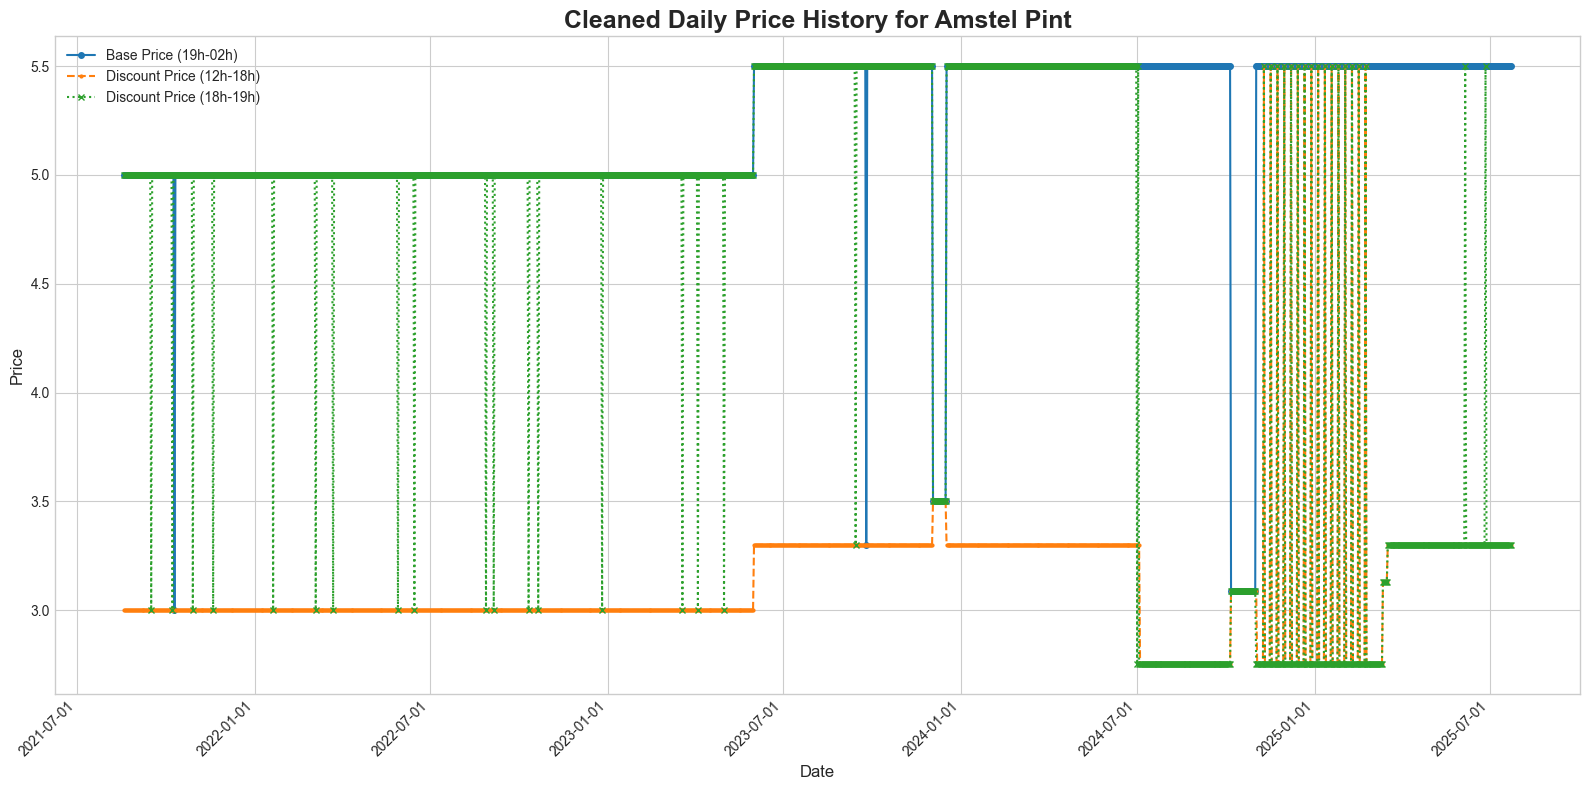

,Period_Start,Period_End,Base_Price,Discount_12_18h,Discount_%_12_18h,Discount_18_19h,Discount_%_18_19h
0,2021-08-19,2021-09-15,5.0,3.0,40%,5.0,0%
1,2021-09-16,2021-09-16,5.0,3.0,40%,3.0,40%
2,2021-09-17,2021-10-07,5.0,3.0,40%,5.0,0%
3,2021-10-08,2021-10-08,5.0,3.0,40%,3.0,40%
4,2021-10-09,2021-10-09,5.0,3.0,40%,5.0,0%
...,...,...,...,...,...,...,...
84,2025-03-17,2025-06-04,5.5,3.3,40%,3.3,40%
85,2025-06-05,2025-06-05,5.5,3.3,40%,5.5,0%
86,2025-06-06,2025-06-25,5.5,3.3,40%,3.3,40%
87,2025-06-26,2025-06-26,5.5,3.3,40%,5.5,0%


In [ ]:
data_path = r'C:\Users\fadia\OneDrive\Desktop\Ody\Scripts\Transformed Data\Master Combined\Master_Sales_Data_2021-08-19_to_2025-07-22.csv'
df=pd.read_csv(data_path)
# i want each satrday from 2024-11-09 until 2025-02-28
exclude_dates = 

generate_time_slot_price_report_pro(df=df,
                                    product_name="Amstel Pint",
                                    exclude_tables=[100,200,500,400],
                                    exclude_payments=["Credit"],
                                    exclude_dates=[]
